# Direkt Marketing mit Amazon SageMaker XGBoost

#### Supervised Learning: Binäre Klassifikation

Letztes Update: April, 2021

In [23]:
!pip -q install --upgrade pip
!pip -q install sagemaker awscli boto3 smdebug --upgrade

___
# TEIL 1 - Herunterladen und Verarbeiten des Datensatzes

Zunächst müssen wir den [direkt marketing datensatz](https://archive.ics.uci.edu/ml/datasets/bank+marketing) von UCI's ML Repository downloaden. Anschließend werden wir die csv-Datei lesen, und für unser ML Modell vorbereiten. Dafür sollten wir erstmal verstehen, was für Daten wir zur Verfügung haben und was wir vorhersagen möchten (= Ziel Variable Y).

Der Datensatz enthält Informationen über Direkt Marketing Kampagnen einer portugiesischen Bank. Diese Kampagnen basieren auf Telefonaten in denen der Kunde ein Produkt (bank term deposit) kaufen kann. Der Ausgang des Telefonates ist in der Variable Y gespeichert und wird Ziel unserer Klassifikation (yes/no) sein. 

Wir möchten also mit unserem ML Model vorhersagen, ob ein Kunde positiv oder negativ auf das Marketing Angebot per Telefon reagiert. 

In [1]:
import zipfile                                    
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2021-04-01 08:20:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   730KB/s    in 0.6s    

2021-04-01 08:20:24 (730 KB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/.

In [2]:
import numpy as np  
import pandas as pd 

In [3]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')
pd.set_option('display.max_columns', 100)     
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Auf den ersten Blick können wir sehen wir haben über 40k Zeilen mit verschiedenen Kundendaten und je 20 beschreibenden Variablen

In [4]:
data.shape # (Anzahl Zeilen, Anzahl Spalten)

(41188, 21)

Zunächst sollten wir ein Gefühl für die Ziel-Variable y und deren Verteilung erhalten. Wir stellen fest, dass wir deutlich mehr "no" Beispiele haben und dementsprechend ein unausgewogenen Datensatz haben:

In [5]:
data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [6]:
print("Verhältnis von negativen zu positiven Werten: {}".format( data['y'].value_counts()[0]/data['y'].value_counts()[1]))

Verhältnis von negativen zu positiven Werten: 7.876724137931035


### Datensatz vorbereiten für Machine Learning Modelle
Den Datensatz zu bereinigen und zu transformieren ist ein signifikanter Teil eines jeden Machine Learning Projekts. Das Behandeln von Ausreißern, das Füllen von fehlenden Werten oder die Erstellung bzw. Transformation neuer Variablen sind nur Beispiele der möglichen Vorbereitungen. Wir tun dies mit dem Ziel wichtige Informationen herauszuarbeiten, die es dem Model einfacher machen zu lernen.

Zunächst können wir uns den Datensatz mit `.describe()` genauer ansehen und nach ersten Auffälligkeiten untersuchen:
Die Variable **pdays** (Anzahl der Tage seitdem letzten Kontakt zum Kunden) z.B. hat als Maximum 999 Tage - das könnte ein Platzhalter sein für den Fall, dass ein Kunde noch gar nicht kontaktiert worden ist. Daher macht es Sinn, eine neue Spalte **no_previous_contact** zu erstellen. Sämtliche Reihen mit `pdays==999` werden eine "0" erhalten, ansonsten "1". Anschließend können wir die Spalte **pdays** löschen.

In [7]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)
data.drop(['pdays'], axis=1, inplace=True)

Die Spalte **job** hat viele Kategorien, die wir in aussagekräftigere Kategorien verwandeln können: 
Da es wahrscheinlich ist, dass die Berufstätigkeit des Kunden einen Einfluss auf die Zielvariable hat, können wir eine neue Variable **not_working** erstellen und dort "student", "retire" und "unemployed" zusammenfassen. 

In [9]:
data['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [10]:
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)

Zu guter letzt kodieren wir die kategorialen Variablen in eine Reihe von Dummy Variablen mit pandas `get_dummies()`Funktion. Das bedeutet, dass wir aus jeder kategorialen Ausprägung einer Variable eine neue Spalte erstellen (auch bekannt als "One-Hot-Encoding".

In [11]:
model_data = pd.get_dummies(data)  # Convert categorical variables to sets of indicators
model_data.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


Nun haben wir aus jeder kategorialen Ausprägung einer Variable (wie z.B.**job**,**marital** etc.) viele neue Variablen erstellt und somit aus 21 schlussendlich 67 Variablen gemacht.

In [12]:
model_data.shape

(41188, 66)

### Unterteilen des Datensatzes

Als nächstes splitten wir den Datensatz in drei seperate Datensätze: (70%), validation (20%) und test (10%). Während des Trainings werden wir versuchen die Performance beim Validation datensatz zu maximieren - sobald das Model fertig bereitgestellt ist, werden wir erneut die Performance auf dem Test datensatz evaluieren. 

Im Folgenden werden wir Amazon SageMaker's XGBoost algorithmus verwenden, welcher Daten entweder im libSVM oder CSV Format erwartet. Im Rahmen dieser Demo, werden wir uns auf das CSV-Format konzentrieren. Die erste Spalte der Datei mus sunsere Zielvariable y sein - ebenso sollte die datei keine Überschriften haben in den Spalten. 

In [13]:
# Set the seed to 123 for reproductibility
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=123), 
                                                  [int(0.7 * len(model_data)), int(0.9*len(model_data))])  

# Drop the two columns for 'yes' and 'no' and add 'yes' back as first column of the dataframe
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

# Dropping the target value, as we will use this CSV file for batch transform
test_data.drop(['y_no','y_yes'], axis=1).to_csv('test.csv', index=False, header=False)

Als nächstes müssen wir die Dateien in Amazon S3 Bucket hochladen:

In [14]:
import sagemaker
import boto3, os

bucket = sagemaker.Session().default_bucket()                     
prefix = 'sagemaker/DEMO-xgboost-dm'

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

Zusätzlich müssen wir SageMaker sagen, wo die Trainings und Validierungs Daten gespeichert sind:

In [15]:
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
s3_data = {'train': s3_input_train, 'validation': s3_input_validation}

---
# Teil 2 - Model erstellen und trainieren

Wie anfangs erläutert, handelt es sich bei unserem use case um ein Klassifizierungsproblem. *XGBoost* ist ein beliebtes open-source Projekt für Gradient Boosting Trees und wurde erfolgreich verwendet in vielen machine learning Wettbewerben! SageMaker bietet eine entsprechendes managed framework an, welches wir im Folgenden benutzen werden:

In [16]:
from sagemaker.estimator import Estimator
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig


sess = sagemaker.Session()
region = boto3.Session().region_name    

container = sagemaker.image_uris.retrieve('xgboost', region,version='0.90-2')


xgb = Estimator(
    container,                                               # container des algorithmus XGBoost)
    role=sagemaker.get_execution_role(),                     # IAM Berechtigungen für SageMaker
    sagemaker_session=sess,                                  # Technisches Objekt
                                    
    input_mode='File',                                       # Kopieren des Datensatzes und anschließendes Trainieren 
    output_path='s3://{}/{}/output'.format(bucket, prefix),  # S3 Pfad, wo das Model gespeichert wird
                                    
    instance_count=1,                                  # Instance Spezifikationen (Infrastruktur)
    instance_type='ml.m4.2xlarge',
                                    
    use_spot_instances=True,                           # Benutzung von spot instance (= unbenutze Kapazitäten & eventuelle Unterbrechung)
    max_run=300,                                       # Maximale Trainingszeit
    max_wait=600,                                      # Maximale Trainingszeit + Wartezeit auf spot instances.
                                    
    debugger_hook_config=DebuggerHookConfig(                 # Speichern von Training Tensors
        s3_output_path='s3://{}/{}/debug'.format(bucket, prefix), 
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": '1'
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": '1'
                }
            )
        ],
    ),
    
    rules=[
        Rule.sagemaker(                                      # Konfiguration der Debugger Regel für Class Imbalance
            rule_configs.class_imbalance(),                  # überwacht z.B. Vorhersage Genauigkeit je Klasse (y/n)
            rule_parameters={
                "collection_names": "metrics"
            },
        ),
    ]
)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210401T094208 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


### Spezifizierung der hyperparameter
Jeder SageMaker integrierte Algorithmus hat verschiedene Hyperparameter, die je nach use case und Dateneigenschaften gesetzt werden müssen. Für XGBoost, gibt es folgende [Hyperparameter](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).

Im Rahmen der Demo werden wir lediglich die folgenden drei Hyperparameter benutzen:
* Binäre Klassifikation: 'binary:logistic'.
* Zur Evaluierung der Performance verwenden wir die 'Area Under Curve' Metrik. 
* Wir möchten maximal 100 Runden trainieren- sollte die AUC Metrik sich in 10 Runden nicht verbessern, beenden wir das Training vorzeitig.  

In [19]:
xgb.set_hyperparameters(
    objective='binary:logistic', 
    eval_metric='auc', 
    num_round=100,
    early_stopping_rounds=10
)

Nun sind alle Parameter spezifiziert und wir können das Training beginnen mit der `.fit()` Funktion und den entsprechenden S3 Pfäden zu den Training/Validation CSV Files.

In [20]:
xgb.fit(s3_data)

2021-04-01 08:24:20 Starting - Starting the training job...
2021-04-01 08:24:44 Starting - Launching requested ML instancesClassImbalance: InProgress
ProfilerReport-1617265459: InProgress
......
2021-04-01 08:25:50 Starting - Preparing the instances for training......
2021-04-01 08:26:50 Downloading - Downloading input data
2021-04-01 08:26:50 Training - Downloading the training image...
2021-04-01 08:27:14 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:D

Anschließend können wir uns die Tensors anschauen, welche während des Trainings gespeichert worden

In [24]:
import smdebug
from smdebug.trials import create_trial

s3_output_path = xgb.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-04-01 08:31:04.995 datascience-1-0-ml-t3-medium-5b87494b3efe79ac159474c0d6df:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-04-01 08:31:05.029 datascience-1-0-ml-t3-medium-5b87494b3efe79ac159474c0d6df:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-west-1-581571165524/sagemaker/DEMO-xgboost-dm/debug/sagemaker-xgboost-2021-04-01-08-24-19-650/debug-output


Um die AUC während des Trainings zu plotten, benötigen wir einige Helfer Funktionen:

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*',figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(collection_name)
    ax.set_xlabel('Iteration')

[2021-04-01 08:31:07.889 datascience-1-0-ml-t3-medium-5b87494b3efe79ac159474c0d6df:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-04-01 08:31:08.909 datascience-1-0-ml-t3-medium-5b87494b3efe79ac159474c0d6df:17 INFO trial.py:210] Loaded all steps


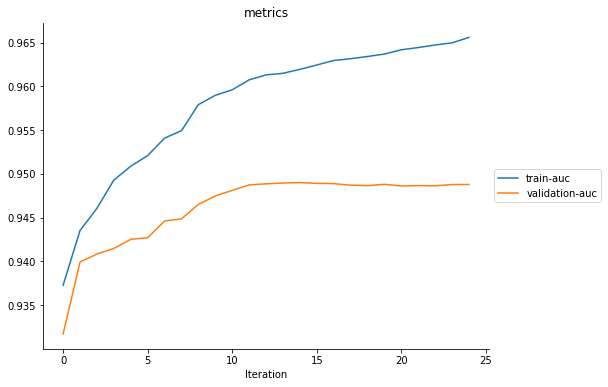

In [26]:
plot_collection(trial, "metrics")

Als nächstes können wir die Feature Importance visualisieren:

In [27]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

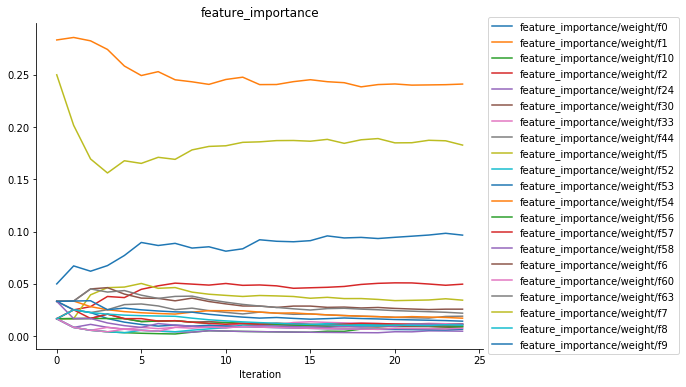

In [28]:
plot_feature_importance(trial)

Variable 1 (job) und 5 (housing) sollten die wichtigsten Variablen sein.

___
# Teil 3 - Bereitstellen und Einsetzen des Models

## Variante 1: Vorhersagen mit einem SageMaker Endpunkt

Nun können wir unser trainiertes Model mit einem HTTPS Endpunkt! Anschließend können wir Daten zu dem Endpunkt senden und eine Vorhersage bzw Klassifkation erhalten.

First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as NumPy arrays in memory of our notebook instance. To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.


In [29]:
from sagemaker.serializers import CSVSerializer
xgb_endpoint = xgb.deploy(
    endpoint_name = 'DEMO-xgboost-dm',
    initial_instance_count = 1,                    
    instance_type = 'ml.m4.xlarge',
    serializer = CSVSerializer()
)

-------------!

In [30]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_endpoint.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy())
predictions

array([0.03546416, 0.20384492, 0.00700124, ..., 0.0068619 , 0.17919968,
       0.43851617])

Es gibt viele Möglichkeiten die Performance von XGBoost zu visualisieren und zu messen: Wir können z.B. mit einer Confusion Matrix erkennen, in welchem Verhältnis Vorhersagen und tatsächliche Werte ("ground truth") stehen.

In [31]:
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,3528,110
1,228,253


Von den ~4000 potenziellen Kunden haben wir also vorhergesagt, dass 136 ein Abonnement abschließen würden, und 94 von ihnen haben es tatsächlich getan. Wir hatten auch 389 Abonnenten, die sich angemeldet haben, die wir nicht vorhergesagt haben. Das ist weniger als wünschenswert, aber das Modell kann (und sollte) abgestimmt werden, um dies zu verbessern

Für jede Stichprobe liefert unser binärer Klassifikator eine Wahrscheinlichkeit zwischen 0 und 1. Da wir uns entschieden haben, die Genauigkeit zu maximieren, legt das Modell einen Schwellenwert von 0,5 fest: Alles, was darunter liegt, wird als 0 behandelt, alles, was darüber liegt, als 1.

Um ein wenig tiefer einzutauchen: Der Schwellenwert ist in der Metrik enthalten, die XGBoost verwendet. Hier verwenden wir die Standard-Metrik "eval_metric" für die Klassifizierung, d. h. "error". Diese Metrik hat einen Standard-Schwellenwert von 0,5. Wenn Sie sich die XGBoost-Dokumentation ansehen (https://xgboost.readthedocs.io/en/latest/parameter.html), werden Sie sehen, dass es möglich ist, einen anderen Schwellenwert zu übergeben. Dafür könnten wir den Hyperparamter des Estimators vor dem Training verändern `xgb.set_hyperparameters(objective='binary:logistic', num_round=100, eval_metric='error@0.2')`

## Variante 2: Vorhersagen mit Batch Transform Jobs
**Zur Erinnerung: test.csv sollte lediglich die features enthalten, jedoch nicht die Zielvariable y. Ebenso sollte die Datei keine Header row enthalten**

Manche Anwendungen benötigen keine HTTPS-basierende real-time Vorhersagen - z.B. einmal die Woche 10GB Daten zu verarbeiten und Vorhersagen zu treffen mit einem endpoint wäre nicht effizient.
Für solche Fehler gibt es die Möglichkeit SageMaker Batch Transforms zu nutzen: Wir kreiren ein Transformer Objekt und senden die Daten von S3 und erhalten ebenfalls die Vorhersagen in S3.

In [32]:
transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge')

transformer.transform('s3://{}/{}/test/test.csv'.format(bucket, prefix), content_type='text/csv')

................................[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping

In [33]:
transformer.wait()
print("Die Batch-Vorhersage wurde hier gespeichert {}".format(transformer.output_path))

[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-04-01:08:43:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameter

### Batch Vorhersagen in S3
Der Output eines Batch Transforms landet in S3:

In [34]:
pd.read_csv(transformer.output_path+'/test.csv.out',header=None )

,0
0,0.035464
1,0.203845
2,0.007001
3,0.007001
4,0.005750
...,...
4114,0.005385
4115,0.007001
4116,0.006862
4117,0.179200


## Löschen des Endpunktes
Sobald wir fertig sind mit dieser Demo sollten wir den Endpoint löschen, um unnötige Kosten zu vermeiden:

In [35]:
sagemaker.Session().delete_endpoint(xgb_endpoint.endpoint_name)